# NOVAscore Financial Risk v.0.2
(02/2026 by David Olivares - NOVAres)

## 1️⃣ Business Context

This analysis simulates the credit risk profile of a diversified corporate lending portfolio composed of:

- **Company sizes**: SME, Mid-sized, and Large firms  
- **Economic sectors**: Cyclical, Industrial, Tech, and Defensive  
- **Credit exposures (EAD)** that evolve under macroeconomic stress  

The objective is to understand how different macroeconomic environments impact:

- Default rates  
- Losses  
- Capital requirements  
- Pricing sustainability  
- Economic profitability  

From a business perspective, this type of framework is relevant for:

- **Banks and credit institutions** managing loan portfolios  
- **Private debt funds** allocating capital across sectors  
- **Corporate lenders** designing risk-based pricing policies  
- **Risk committees and CFOs** assessing capital resilience  
- **Strategy teams** evaluating concentration risk  

The core business questions addressed are:

- How much capital do we need under stress?
- Is our current pricing sufficient?
- Which segments and sectors drive capital inflation?
- Where are we structurally underpricing risk?
- How does macro deterioration translate into profitability erosion?

In short, this is a **risk → capital → pricing → profit** integrated framework designed for strategic decision-making.

---

## 2️⃣ Data Science & Modeling Context

From a data science perspective, this framework combines several modeling layers:

### 🔹 1. Latent Quality Model
Each firm is assigned a dynamic latent financial quality factor (**Q_t**) influenced by:
- Firm segment effects  
- Sector structural effects  
- Macro stress sensitivity  
- Idiosyncratic noise  

This creates a coherent economic structure rather than purely random simulation.

---

### 🔹 2. Structural Credit Risk Modeling

Using Q_t and macro stress, we generate:

- **PD (Probability of Default)** via a logistic transformation  
- **LGD (Loss Given Default)** with stress-dependent dynamics  
- **EAD (Exposure at Default)** incorporating stress-driven utilization  

Defaults are simulated as Bernoulli draws consistent with PD.

This ensures:
- Internal coherence between model PD and realized default rate  
- Realistic stress amplification dynamics  

---

### 🔹 3. Economic Capital Approximation

We compute:

\[
EC = EL + z \cdot UL
\]

Where:
- EL = Expected Loss  
- UL = Unexpected Loss proxy  
- z = 2.33 (≈ 99% confidence level)

This provides a simplified but economically interpretable capital requirement proxy.

---

### 🔹 4. Risk-Based Pricing Model

We derive:

\[
Required\ Return = EL + Cost\ of\ Capital \times EC
\]

\[
Required\ Spread = \frac{Required\ Return}{EAD}
\]

This links credit risk directly to pricing decisions.

---

### 🔹 5. Scenario Analysis & Attribution

The framework evaluates:

- Break-even spreads  
- Economic profit under fixed market pricing  
- Contribution to capital inflation by:
  - Segment
  - Sector
  - Segment × Sector  

This allows structural stress testing and concentration diagnostics.

---

# 🎯 Overall Concept

This is a synthetic but economically coherent **macro-stress credit simulation engine**.

It integrates:

Macroeconomic stress → Firm deterioration → PD/LGD/EAD → Losses → Capital → Pricing → Profitability.

The result is a unified decision-support tool for:

- Risk management  
- Capital planning  
- Pricing governance  
- Strategic portfolio allocation  
- Early-warning stress monitoring  

It bridges business strategy and quantitative modeling in a transparent, interpretable way.

In [15]:
import numpy as np
import pandas as pd

# ------------------------------
# Helper: logistic link function
# ------------------------------
def sigmoid(x):
    # Converts a latent score (log-odds) into a probability in (0, 1)
    return 1.0 / (1.0 + np.exp(-x))

def generate_novascore_v2_scenarios(
    N=5000,
    seed=42,
    target_baseline_default_rate=0.06,
    scenario_path=None,
):
    # ------------------------------
    # Reproducibility + scenario setup
    # ------------------------------
    # Random generator (modern NumPy RNG) for reproducible simulation
    rng = np.random.default_rng(seed)

    # If no scenario path is provided, define 4 macro-stress levels:
    # Baseline (0), Mild (0.3), Adverse (0.7), Severe (1.2)
    if scenario_path is None:
        scenario_path = [0.00, 0.30, 0.70, 1.20]  # Baseline, Mild, Adverse, Severe

    # Number of scenario time steps / states
    T = len(scenario_path)

    # ------------------------------
    # Portfolio structure
    # ------------------------------
    # Discrete firm segmentation (size) and sector classification
    segments = ["SME", "Mid", "Large"]
    sectors = ["Cyclical", "Defensive", "Tech", "Industrial"]

    # Static effects on latent "quality" at time 0:
    # segment_effect: larger firms start with higher average quality
    # sector_effect: some sectors start structurally stronger/weaker
    segment_effect = {"SME": -0.6, "Mid": 0.0, "Large": 0.6}
    sector_effect = {"Cyclical": -0.5, "Defensive": 0.4, "Tech": 0.2, "Industrial": -0.2}

    # Sector sensitivity controls how strongly macro stress deteriorates latent quality
    sector_sensitivity = {"Cyclical": 1.5, "Defensive": 0.6, "Tech": 1.0, "Industrial": 1.2}

    # Create N entities (firms) with segment + sector assignments
    entities = pd.DataFrame({
        "firm_id": np.arange(N),
        # Segment distribution is intentionally skewed: more SMEs than Large
        "segment": rng.choice(segments, size=N, p=[0.5, 0.3, 0.2]),
        "sector": rng.choice(sectors, size=N)
    })

    # Initial latent quality Q_0 per firm:
    # segment effect + sector effect + idiosyncratic noise
    entities["Q_0"] = (
        entities["segment"].map(segment_effect).astype(float)
        + entities["sector"].map(sector_effect).astype(float)
        + rng.normal(0, 1, size=N)
    )

    # We will build a panel dataset by stacking rows per (firm, scenario step)
    rows = []

    # Track previous latent quality to make Q_t a dynamic process
    Q_prev = entities["Q_0"].to_numpy()

    # Precompute arrays for faster vector operations
    sens = entities["sector"].map(sector_sensitivity).to_numpy()
    seg = entities["segment"].to_numpy()
    sec = entities["sector"].to_numpy()

    # Placeholder to store the baseline latent default driver (Z_raw) at t=0
    # used later to calibrate the PD intercept to the requested baseline default rate
    baseline_Z_raw = None

    # ------------------------------
    # Scenario loop: generate firm dynamics under each macro stress level
    # ------------------------------
    for t in range(T):
        # Current macro stress intensity (scalar for the scenario step)
        macro_t = float(scenario_path[t])

        # Latent quality deterioration:
        # firms lose quality as macro stress increases, scaled by sector sensitivity,
        # plus some firm-level idiosyncratic noise each step
        Q_t = Q_prev - 0.35 * sens * macro_t + rng.normal(0, 0.5, size=N)

        # ------------------------------
        # Generate observable financial variables from latent quality + macro stress
        # ------------------------------
        # The signs are chosen so that:
        # - higher Q_t => better profitability, better liquidity, better coverage, lower leverage
        # - higher macro_t => generally worsens metrics
        profitability = 0.8 * Q_t - 0.15 * macro_t + rng.normal(0, 0.3, size=N)
        leverage = -0.7 * Q_t + 0.35 * macro_t + rng.normal(0, 0.4, size=N)
        interest_coverage = 1.0 * Q_t - 0.45 * macro_t + rng.normal(0, 0.4, size=N)
        liquidity = 0.6 * Q_t - 0.25 * macro_t + rng.normal(0, 0.3, size=N)

        # Days past due as a non-negative delinquency proxy:
        # worse quality and higher macro stress increases DPD
        days_past_due = np.maximum(
            0,
            5 - 2 * Q_t + 1.0 * macro_t + rng.normal(0, 1, size=N)
        )

        # Previous default history proxy:
        # firms with very poor quality have higher probability of having previously defaulted
        p_prev = np.where(Q_t < -1.0, 0.06, 0.01)
        num_previous_defaults = rng.binomial(1, p_prev, size=N)

        # ------------------------------
        # Default driver: latent risk score (log-odds before intercept calibration)
        # ------------------------------
        # Z_raw increases with:
        # - higher leverage (quadratic to overweight extreme leverage)
        # - lower interest coverage (negative term)
        # - higher macro stress (direct term + interaction with leverage)
        # - higher delinquency (days past due)
        # - prior default indicator
        Z_raw = (
            0.8 * (leverage ** 2)
            - 1.0 * interest_coverage
            + 0.25 * macro_t
            + 0.35 * (leverage * macro_t)
            + 0.08 * days_past_due
            + 0.6 * num_previous_defaults
        )

        # Save baseline Z_raw (t=0) to calibrate the intercept later
        if t == 0:
            baseline_Z_raw = Z_raw.copy()

        # ------------------------------
        # LGD (Loss Given Default) dynamics
        # ------------------------------
        # Base LGD rises with macro stress (recoveries worsen in downturns),
        # and is additionally higher for Cyclical sectors
        lgd_base = 0.35 + 0.18 * macro_t + 0.08 * (sec == "Cyclical").astype(float)

        # Add noise and clip to a realistic range
        LGD = np.clip(lgd_base + rng.normal(0, 0.05, size=N), 0.2, 0.8)

        # ------------------------------
        # EAD (Exposure at Default) dynamics
        # ------------------------------
        # Base exposure comes from a lognormal distribution with segment-dependent mean:
        # larger firms tend to have higher exposure scale
        ead_loc = np.where(seg == "SME", 9.7, np.where(seg == "Mid", 10.2, 10.7))
        base_EAD = rng.lognormal(mean=ead_loc, sigma=0.6, size=N)

        # Stress uplift: under worse macro stress, utilization/credit drawdowns increase,
        # especially for SMEs (more fragile liquidity behavior)
        stress_uplift = 1 + (0.12 + 0.08 * (seg == "SME").astype(float)) * macro_t
        EAD = base_EAD * np.clip(stress_uplift, 0.8, 1.5)

        # ------------------------------
        # Scenario label (friendly names if exactly 4 steps)
        # ------------------------------
        scenario_names = ["Baseline", "Mild", "Adverse", "Severe"]
        scen = scenario_names[t] if T == 4 else f"t{t}"

        # Store the step as a DataFrame (one row per firm)
        df_t = pd.DataFrame({
            "firm_id": entities["firm_id"],
            "year": t,                 # scenario index / time step
            "scenario": scen,          # human-readable scenario name
            "segment": seg,
            "sector": sec,
            "macro_stress": macro_t,   # stress level used in this step
            "Q_t": Q_t,                # latent quality at this step
            "profitability": profitability,
            "leverage": leverage,
            "interest_coverage": interest_coverage,
            "liquidity": liquidity,
            "days_past_due": days_past_due,
            "num_previous_defaults": num_previous_defaults,
            "Z_raw": Z_raw,            # latent default driver (pre-calibration)
            "LGD": LGD,
            "EAD": EAD
        })

        # Append to list for later concatenation into a panel
        rows.append(df_t)

        # Update latent state for next step (makes it dynamic across scenarios/years)
        Q_prev = Q_t

    # Concatenate all scenario steps into a single panel dataset
    df = pd.concat(rows, ignore_index=True)

    # ------------------------------
    # Calibrate intercept on Baseline
    # ------------------------------
    # Goal: find delta such that mean(sigmoid(Z0 + delta)) ~= target_baseline_default_rate
    # We do this with a simple bisection search over delta.
    Z0 = baseline_Z_raw
    lo, hi = -20.0, 20.0
    for _ in range(80):
        mid = 0.5 * (lo + hi)
        m = sigmoid(Z0 + mid).mean()
        if m > target_baseline_default_rate:
            hi = mid
        else:
            lo = mid
    delta = 0.5 * (lo + hi)

    # ------------------------------
    # Compute "true" PD and simulate defaults
    # ------------------------------
    # PD_true is the calibrated probability of default per (firm, step)
    df["PD_true"] = sigmoid(df["Z_raw"].to_numpy() + delta)

    # Realized default is a Bernoulli draw from PD_true
    df["default"] = rng.binomial(1, df["PD_true"].to_numpy())

    # Expected Loss per observation: EL = PD * LGD * EAD
    df["Expected_Loss"] = df["PD_true"] * df["LGD"] * df["EAD"]

    # ------------------------------
    # Return a quick summary of calibration + baseline behavior
    # ------------------------------
    summary = {
        "target_baseline_default_rate": target_baseline_default_rate,
        "baseline_mean_PD": float(df.loc[df["scenario"] == "Baseline", "PD_true"].mean()),
        "baseline_default_rate_realized": float(df.loc[df["scenario"] == "Baseline", "default"].mean()),
        "calibration_delta": float(delta),
        "scenario_path": scenario_path,
    }

    return df, entities, summary


# ---- RUN ----
# Generate a simulated portfolio panel under 4 macro scenarios
df_s, entities_s, summary_s = generate_novascore_v2_scenarios(
    N=5000,
    seed=42,
    target_baseline_default_rate=0.06,
    scenario_path=[0.00, 0.30, 0.70, 1.20]
)

# Print calibration + baseline checks
print(summary_s)

# Aggregate performance by scenario: realized default rate, mean PD, mean expected loss
by_scenario = df_s.groupby("scenario").agg(
    macro_stress=("macro_stress", "mean"),
    default_rate=("default", "mean"),
    mean_PD=("PD_true", "mean"),
    mean_EL=("Expected_Loss", "mean"),
)

print(by_scenario)

# Preview the first rows of the simulated panel
df_s.head()

{'target_baseline_default_rate': 0.06, 'baseline_mean_PD': 0.05999999999999999, 'baseline_default_rate_realized': 0.064, 'calibration_delta': -6.029290347376703, 'scenario_path': [0.0, 0.3, 0.7, 1.2]}
          macro_stress  default_rate   mean_PD      mean_EL
scenario                                                   
Adverse            0.7        0.1980  0.200127  2927.890674
Baseline           0.0        0.0640  0.060000   557.275733
Mild               0.3        0.1068  0.105461  1125.930542
Severe             1.2        0.3718  0.374337  7125.717203


,firm_id,year,scenario,segment,sector,macro_stress,Q_t,profitability,leverage,interest_coverage,liquidity,days_past_due,num_previous_defaults,Z_raw,LGD,EAD,PD_true,default,Expected_Loss
0,0,0,Baseline,Mid,Defensive,0.0,0.392274,0.074454,-0.704557,0.731927,0.282028,4.294695,0,0.008768,0.303099,23825.109669,0.002423,0,17.493885
1,1,0,Baseline,SME,Cyclical,0.0,-2.334580,-1.859695,1.593518,-2.293992,-1.595328,9.022206,0,5.047208,0.469255,26592.289959,0.272479,0,3400.147309
2,2,0,Baseline,Large,Tech,0.0,0.537253,0.210842,-0.540968,0.685909,0.104203,5.232584,0,-0.033185,0.392917,68218.972004,0.002323,0,62.272516
3,3,0,Baseline,Mid,Tech,0.0,-1.216324,-1.091869,1.205688,-1.446499,-0.629299,7.329667,0,3.195820,0.350596,49039.353553,0.055542,0,954.933374
4,4,0,Baseline,SME,Defensive,0.0,0.121922,0.483860,-0.061161,-0.193159,-0.286076,5.853691,0,0.664447,0.362503,14491.834194,0.004656,0,24.461643


# 📌 NovaScore v2 – Clear Explanation and Interpretation of Results

## 1️⃣ What does this model do?

NovaScore v2 simulates how a portfolio of 5,000 firms behaves under different macroeconomic stress levels.

Each firm has:
- A structural profile (segment + sector)
- A latent financial quality factor (Q_t)
- Financial ratios derived from that quality
- A Probability of Default (PD)
- A Loss Given Default (LGD)
- An Exposure at Default (EAD)

The model computes:

Expected Loss = PD × LGD × EAD

The key intuition:

As macro stress increases → firms deteriorate → defaults rise → losses increase.

We simulate four macroeconomic states:

- Baseline (0.0)
- Mild (0.3)
- Adverse (0.7)
- Severe (1.2)

------------------------------------------------------------

## 2️⃣ Calibration Results (Baseline)

{
 'target_baseline_default_rate': 0.06,
 'baseline_mean_PD': 0.0600,
 'baseline_default_rate_realized': 0.064,
 'calibration_delta': -6.03
}

Interpretation:

- The model was calibrated to achieve a 6% baseline PD.
- The resulting mean PD is exactly 6%.
- The realized default rate (6.4%) is consistent with statistical noise.
- The calibration_delta (-6.03) is simply the intercept shift needed to align the logistic PD with the 6% target.

Conclusion:  
The baseline calibration works correctly and is internally coherent.

------------------------------------------------------------

## 3️⃣ Portfolio Behavior Under Stress

Scenario Results:

Baseline:
- Default Rate: 6.4%
- Mean PD: 6.0%
- Mean Expected Loss: 557

Mild:
- Default Rate: 10.7%
- Mean PD: 10.5%
- Mean Expected Loss: 1,126

Adverse:
- Default Rate: 19.8%
- Mean PD: 20.0%
- Mean Expected Loss: 2,928

Severe:
- Default Rate: 37.2%
- Mean PD: 37.4%
- Mean Expected Loss: 7,126

------------------------------------------------------------

## 4️⃣ Interpretation of the Stress Results

The model shows progressive and nonlinear deterioration:

- Default rate increases from 6% to 37%.
- Expected Loss increases from 557 to 7,126.
- Losses multiply by approximately 13x between Baseline and Severe.

This happens because three components worsen simultaneously:

1) PD increases (more firms default)
2) LGD increases (recoveries worsen in crisis)
3) EAD increases (firms draw more credit under stress)

Since Expected Loss = PD × LGD × EAD,
the increase is multiplicative, not linear.

------------------------------------------------------------

## 5️⃣ Micro-Level Consistency

Individual firm examples show:

- Strong firms → PD ≈ 0.2%
- Weak, leveraged firms → PD > 25%
- Expected Loss becomes large only when high PD, high LGD, and high EAD coincide.

This confirms the model behaves realistically at firm level.

------------------------------------------------------------

# 🎯 Final Conclusion

NovaScore v2:

- Is correctly calibrated at baseline.
- Reacts progressively to macro stress.
- Produces nonlinear loss amplification.
- Is economically coherent at portfolio and firm level.

In practical terms:

The model provides a structurally consistent framework for macro-scenario credit risk simulation and stress testing.

,n,default_rate,mean_PD,mean_LGD,mean_EAD,total_EAD,total_EL,total_UL,total_EC,EL_per_EAD,EC_per_EAD
scenario,,,,,,,,,,,
Adverse,5000,0.1980,0.200127,0.496228,33081.912471,1.654096e+08,1.463945e+07,1.463406e+07,4.873681e+07,0.088504,0.294643
Baseline,5000,0.0640,0.060000,0.368815,29621.713969,1.481086e+08,2.786379e+06,6.326191e+06,1.752640e+07,0.018813,0.118335
Mild,5000,0.1068,0.105461,0.423138,30739.261962,1.536963e+08,5.629653e+06,9.159109e+06,2.697038e+07,0.036628,0.175478
Severe,5000,0.3718,0.374337,0.585385,35225.663966,1.761283e+08,3.562859e+07,2.122410e+07,8.508074e+07,0.202288,0.483061


,total_EAD,total_EL,delta_total_EL,pct_total_EL,total_EC,delta_total_EC,pct_total_EC,EL_per_EAD,delta_EL_per_EAD,pct_EL_per_EAD,EC_per_EAD,delta_EC_per_EAD,pct_EC_per_EAD
scenario,,,,,,,,,,,,,
Adverse,1.654096e+08,1.463945e+07,1.185307e+07,4.253935,4.873681e+07,3.121040e+07,1.780765,0.088504,0.069691,3.704401,0.294643,0.176308,1.489911
Baseline,1.481086e+08,2.786379e+06,0.000000e+00,0.000000,1.752640e+07,0.000000e+00,0.000000,0.018813,0.000000,0.000000,0.118335,0.000000,0.000000
Mild,1.536963e+08,5.629653e+06,2.843274e+06,1.020419,2.697038e+07,9.443974e+06,0.538843,0.036628,0.017815,0.946965,0.175478,0.057144,0.482897
Severe,1.761283e+08,3.562859e+07,3.284221e+07,11.786699,8.508074e+07,6.755434e+07,3.854433,0.202288,0.183475,9.752500,0.483061,0.364726,3.082155


,scenario,segment,total_EAD,total_EC,delta_EC_vs_base,contrib_share_delta_EC
2,Adverse,SME,5.611241e+07,2.120057e+07,1.281631e+07,0.410642
1,Adverse,Mid,5.194826e+07,1.540440e+07,1.028480e+07,0.329531
0,Adverse,Large,5.734889e+07,1.213184e+07,8.109294e+06,0.259827
8,Mild,SME,5.234793e+07,1.282306e+07,4.438807e+06,0.470015
7,Mild,Mid,4.756785e+07,8.014618e+06,2.895014e+06,0.306546
6,Mild,Large,5.378053e+07,6.132700e+06,2.110153e+06,0.223439
11,Severe,SME,6.056102e+07,3.458792e+07,2.620367e+07,0.387890
10,Severe,Mid,5.454494e+07,2.698350e+07,2.186390e+07,0.323649
9,Severe,Large,6.102235e+07,2.350932e+07,1.948678e+07,0.288461


,scenario,sector,total_EAD,total_EC,delta_EC_vs_base,contrib_share_delta_EC
0,Adverse,Cyclical,4.241509e+07,1.818194e+07,1.149568e+07,0.368328
2,Adverse,Industrial,3.995536e+07,1.279888e+07,8.353750e+06,0.267659
3,Adverse,Tech,4.243569e+07,1.020124e+07,6.602304e+06,0.211542
1,Adverse,Defensive,4.060343e+07,7.554743e+06,4.758673e+06,0.152471
8,Mild,Cyclical,3.929325e+07,1.038775e+07,3.701481e+06,0.391941
10,Mild,Industrial,3.621619e+07,6.914438e+06,2.469304e+06,0.261469
11,Mild,Tech,3.851890e+07,5.302245e+06,1.703310e+06,0.180359
9,Mild,Defensive,3.966796e+07,4.365948e+06,1.569878e+06,0.166231
12,Severe,Cyclical,4.449613e+07,2.991480e+07,2.322854e+07,0.343850
14,Severe,Industrial,4.236246e+07,2.153333e+07,1.708819e+07,0.252955


,segment,sector,delta_EC_vs_base,total_EC,total_EAD
40,Mid,Cyclical,8.111597e+06,1.004851e+07,1.481751e+07
44,SME,Cyclical,7.751764e+06,1.094565e+07,1.489298e+07
36,Large,Cyclical,7.365177e+06,8.920648e+06,1.478564e+07
46,SME,Industrial,6.789580e+06,8.852058e+06,1.475426e+07
47,SME,Tech,6.534677e+06,8.411234e+06,1.637570e+07
42,Mid,Industrial,5.211168e+06,6.543466e+06,1.224135e+07
45,SME,Defensive,5.127646e+06,6.378978e+06,1.453808e+07
38,Large,Industrial,5.087445e+06,6.137803e+06,1.536685e+07
43,Mid,Tech,4.701127e+06,5.728570e+06,1.327742e+07
39,Large,Tech,4.189548e+06,4.884482e+06,1.512286e+07


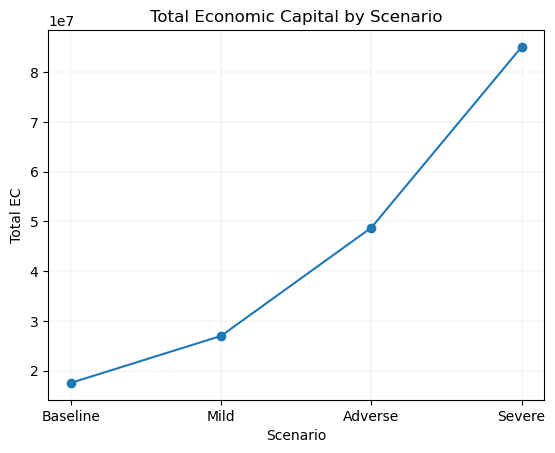

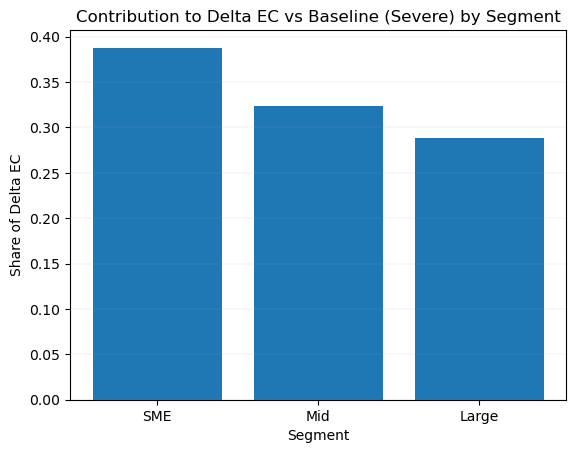

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# ECONOMIC CAPITAL (DEMO) — Scenario + Segment/Sector Attribution
# ============================================================
# Goal of this block:
#   1) Translate the simulated credit outcomes (PD, LGD, EAD) into loss and capital views:
#        - Expected Loss (EL): average loss level we expect to realize
#        - Unexpected Loss (UL): volatility around that expectation (risk / uncertainty)
#        - Economic Capital (EC): a high-quantile cushion = EL + z * UL
#   2) Summarize these metrics at portfolio level by scenario
#   3) Express stress impact vs Baseline (absolute delta + % change)
#   4) Attribute the increase in capital under stress to:
#        - segments (SME / Mid / Large)
#        - sectors (Cyclical / Defensive / Tech / Industrial)
#   5) Produce simple slide-friendly plots

# ----------------------------
# 1) Capital formulas
# ----------------------------
# Start from the simulated panel df_s (firm x scenario step) and compute capital metrics.
# Note: df_s already contains Expected_Loss, but we recompute EL here to keep this block
# fully self-consistent and avoid dependency on prior column naming.
df_cap = df_s.copy()
df_cap["EL"] = df_cap["PD_true"] * df_cap["LGD"] * df_cap["EAD"]

# Unexpected Loss proxy at obligor level:
# - sqrt(PD*(1-PD)) acts like the standard deviation of a Bernoulli default indicator
# - scaling by LGD*EAD converts "default volatility" into "loss volatility"
# This is NOT a full Basel IRB model (no asset correlation / maturity adjustment),
# but it provides an economically intuitive risk proxy for scenario comparison.
df_cap["UL"] = np.sqrt(df_cap["PD_true"] * (1.0 - df_cap["PD_true"])) * df_cap["LGD"] * df_cap["EAD"]

# Economic Capital (EC):
# Define EC as a conservative buffer equal to expected loss plus a multiple of unexpected loss.
# z = 2.33 approximates the 99th percentile of a standard normal distribution.
# Interpretation: "hold enough capital to cover EL plus a 99% stress cushion around it."
Z = 2.33
df_cap["EC"] = df_cap["EL"] + Z * df_cap["UL"]

# ----------------------------
# 2) Portfolio-level summary by scenario
# ----------------------------
# Aggregate firm-level metrics into a scenario-level portfolio view.
# We report both averages (rates/means) and totals (portfolio sums).
port = df_cap.groupby("scenario").agg(
    n=("firm_id", "count"),                 # number of firm-observations in the scenario
    default_rate=("default", "mean"),       # realized default frequency (simulation draw)
    mean_PD=("PD_true", "mean"),            # average model-implied PD
    mean_LGD=("LGD", "mean"),               # average loss given default
    mean_EAD=("EAD", "mean"),               # average exposure at default
    total_EAD=("EAD", "sum"),               # total exposure in the portfolio
    total_EL=("EL", "sum"),                 # total expected loss = sum(PD*LGD*EAD)
    total_UL=("UL", "sum"),                 # total risk proxy (additive demo proxy)
    total_EC=("EC", "sum"),                 # total "economic capital" for the portfolio
).sort_index()

# Per-exposure normalization:
# These ratios are often more intuitive for management slides because they scale out portfolio size.
# - EL_per_EAD: expected loss rate per unit of exposure
# - EC_per_EAD: capital intensity per unit of exposure
port["EL_per_EAD"] = port["total_EL"] / port["total_EAD"]
port["EC_per_EAD"] = port["total_EC"] / port["total_EAD"]

display(port)

# ----------------------------
# 3) Delta vs Baseline (portfolio)
# ----------------------------
# Quantify how much stress increases losses/capital relative to Baseline.
# We compute:
#   - delta_* : absolute change vs Baseline
#   - pct_*   : percentage change vs Baseline
baseline = port.loc["Baseline"]

port_delta = port.copy()
for col in ["total_EL", "total_UL", "total_EC", "EL_per_EAD", "EC_per_EAD", "mean_PD", "default_rate", "mean_LGD"]:
    port_delta[f"delta_{col}"] = port_delta[col] - baseline[col]
    port_delta[f"pct_{col}"] = (port_delta[col] / baseline[col]) - 1.0

# Compact "stress impact" view for slides:
# shows exposure, loss, and capital — both in absolute terms and relative to baseline.
display(port_delta[[
    "total_EAD",
    "total_EL", "delta_total_EL", "pct_total_EL",
    "total_EC", "delta_total_EC", "pct_total_EC",
    "EL_per_EAD", "delta_EL_per_EAD", "pct_EL_per_EAD",
    "EC_per_EAD", "delta_EC_per_EAD", "pct_EC_per_EAD",
]])

# ----------------------------
# 4) Segment decomposition: contributions to Delta EC vs Baseline
# ----------------------------
# Purpose:
# Explain *who* (which segments) drives the increase in capital under stress.
# Steps:
#   1) Compute total EC per (scenario, segment)
#   2) Merge baseline EC for each segment
#   3) Compute delta EC vs baseline for each segment within each scenario
#   4) Convert segment deltas into contribution shares (sum to ~1 per scenario)
seg = df_cap.groupby(["scenario", "segment"]).agg(
    total_EAD=("EAD", "sum"),
    total_EC=("EC", "sum"),
    total_EL=("EL", "sum"),
).reset_index()

# Baseline reference per segment (used as the "counterfactual" anchor)
seg_base = seg[seg["scenario"] == "Baseline"][["segment", "total_EC", "total_EL", "total_EAD"]].rename(
    columns={"total_EC":"base_EC", "total_EL":"base_EL", "total_EAD":"base_EAD"}
)

seg = seg.merge(seg_base, on="segment", how="left")
seg["delta_EC_vs_base"] = seg["total_EC"] - seg["base_EC"]
seg["delta_EL_vs_base"] = seg["total_EL"] - seg["base_EL"]

# Contribution share:
# For each scenario, total delta EC is the sum across segments.
# Each segment's share tells you how much it explains of the stress-driven increase.
seg["scenario_delta_EC_total"] = seg.groupby("scenario")["delta_EC_vs_base"].transform("sum")
seg["contrib_share_delta_EC"] = np.where(
    seg["scenario"] == "Baseline",
    0.0,
    seg["delta_EC_vs_base"] / seg["scenario_delta_EC_total"]
)

# Output table focused on stressed scenarios (exclude Baseline)
seg_out = seg[seg["scenario"] != "Baseline"].sort_values(["scenario", "delta_EC_vs_base"], ascending=[True, False])
display(seg_out[["scenario", "segment", "total_EAD", "total_EC", "delta_EC_vs_base", "contrib_share_delta_EC"]])

# ----------------------------
# 5) Sector decomposition: contributions to Delta EC vs Baseline
# ----------------------------
# Same logic as segment decomposition, but now answering:
# "Which sectors explain the increase in capital under stress?"
sec = df_cap.groupby(["scenario", "sector"]).agg(
    total_EAD=("EAD", "sum"),
    total_EC=("EC", "sum"),
    total_EL=("EL", "sum"),
).reset_index()

sec_base = sec[sec["scenario"] == "Baseline"][["sector", "total_EC", "total_EL", "total_EAD"]].rename(
    columns={"total_EC":"base_EC", "total_EL":"base_EL", "total_EAD":"base_EAD"}
)

sec = sec.merge(sec_base, on="sector", how="left")
sec["delta_EC_vs_base"] = sec["total_EC"] - sec["base_EC"]
sec["delta_EL_vs_base"] = sec["total_EL"] - sec["base_EL"]

sec["scenario_delta_EC_total"] = sec.groupby("scenario")["delta_EC_vs_base"].transform("sum")
sec["contrib_share_delta_EC"] = np.where(
    sec["scenario"] == "Baseline",
    0.0,
    sec["delta_EC_vs_base"] / sec["scenario_delta_EC_total"]
)

sec_out = sec[sec["scenario"] != "Baseline"].sort_values(["scenario", "delta_EC_vs_base"], ascending=[True, False])
display(sec_out[["scenario", "sector", "total_EAD", "total_EC", "delta_EC_vs_base", "contrib_share_delta_EC"]])

# ----------------------------
# 6) Optional: segment x sector heatmap-style table (no plotting)
# ----------------------------
# Goal:
# Identify the most stressed "cells" (segment-sector combinations) contributing to higher EC.
# This is a quick diagnostic for concentration: "where does the capital blow-up come from?"
segsec = df_cap.groupby(["scenario", "segment", "sector"]).agg(
    total_EC=("EC", "sum"),
    total_EAD=("EAD", "sum"),
).reset_index()

# Compute delta EC vs baseline for each segment-sector cell
base_segsec = segsec[segsec["scenario"] == "Baseline"][["segment", "sector", "total_EC"]].rename(columns={"total_EC":"base_EC"})
segsec = segsec.merge(base_segsec, on=["segment","sector"], how="left")
segsec["delta_EC_vs_base"] = segsec["total_EC"] - segsec["base_EC"]

# Show top 10 contributors in the Severe scenario (largest absolute delta EC)
severe_top = segsec[segsec["scenario"] == "Severe"].sort_values("delta_EC_vs_base", ascending=False).head(10)
display(severe_top[["segment","sector","delta_EC_vs_base","total_EC","total_EAD"]])

# ----------------------------
# 7) Plots (simple, slide-friendly)
# ----------------------------
# These plots are designed to be:
# - minimal styling
# - easy to paste into decks
# - focused on the main narrative: "capital rises with stress" and "who drives it"

# Plot total EC by scenario (portfolio-level capital requirement)
plt.figure()
port_plot = port.loc[["Baseline","Mild","Adverse","Severe"]]
plt.plot(port_plot.index, port_plot["total_EC"], marker="o")
plt.title("Total Economic Capital by Scenario")
plt.ylabel("Total EC")
plt.xlabel("Scenario")
plt.grid(True, linewidth=0.3, alpha=0.4)
plt.show()

# Plot contribution share by segment in the Severe scenario:
# answers: "In Severe, which segment explains most of the delta EC vs Baseline?"
plt.figure()
sev_seg = seg_out[seg_out["scenario"] == "Severe"].copy()
plt.bar(sev_seg["segment"], sev_seg["contrib_share_delta_EC"])
plt.title("Contribution to Delta EC vs Baseline (Severe) by Segment")
plt.ylabel("Share of Delta EC")
plt.xlabel("Segment")
plt.grid(True, axis="y", linewidth=0.3, alpha=0.4)
plt.show()

# 📊 Economic Capital Stress Test – Interpretation of Results

## 1️⃣ Portfolio-Level Dynamics

The portfolio shows a clear and economically coherent stress response.

### Baseline
- Default rate: **6.4%**
- Mean PD: **6.0%**
- Mean LGD: **36.9%**
- Total Economic Capital (EC): **17.5M**
- EC per EAD: **11.8%**

This represents a normal operating environment with moderate capital intensity.

---

### Mild Scenario
- Default rate rises to **10.7%**
- Total EL increases by **+102%**
- Total EC increases by **+54%**
- EC per EAD rises from **11.8% → 17.5%**

Interpretation:
Even moderate macro stress nearly doubles expected losses.  
Capital requirements increase materially but remain controlled.

---

### Adverse Scenario
- Default rate reaches **19.8%**
- Total EL increases by **+425%**
- Total EC increases by **+178%**
- EC per EAD rises to **29.5%**

Interpretation:
Risk is no longer linear. Losses and capital begin accelerating.
The system is entering a structurally stressed regime.

---

### Severe Scenario
- Default rate explodes to **37.2%**
- Total EL increases by **+1,178%**
- Total EC increases by **+385%**
- EC per EAD rises from **11.8% → 48.3%**

Interpretation:
Capital intensity quadruples relative to baseline.
Loss amplification is nonlinear because:

- PD rises sharply
- LGD increases (recoveries deteriorate)
- EAD expands (stress-driven utilization)

The combined effect creates a strong multiplicative shock.

---

# 2️⃣ Segment Contribution to Stress Capital (Delta EC vs Baseline)

## Severe Scenario Contribution Share

- SME: **38.8%**
- Mid: **32.4%**
- Large: **28.8%**

Interpretation:

SMEs are the largest contributors to capital deterioration under stress.
This is structurally consistent because:

- SMEs are more sensitive to macro shocks
- Their EAD grows more under stress
- Their PD deteriorates faster

However, the distribution is relatively balanced — stress is systemic, not concentrated in a single segment.

---

# 3️⃣ Sector Contribution to Stress Capital

## Severe Scenario Contribution Share

- Cyclical: **34.4%**
- Industrial: **25.3%**
- Tech: **22.8%**
- Defensive: **17.5%**

Interpretation:

Cyclical sectors dominate capital deterioration.
This is economically intuitive:

- Cyclicals are more sensitive to macro downturns
- Their LGD and PD rise more aggressively

Defensive sectors contribute the least, confirming the model captures sector heterogeneity correctly.

---

# 4️⃣ Concentration Hotspots (Segment × Sector)

Top Severe contributors include:

- Mid–Cyclical
- SME–Cyclical
- Large–Cyclical
- SME–Industrial
- SME–Tech

Interpretation:

Cyclical exposure across all segments drives a large portion of capital inflation.
SME exposure within stressed sectors amplifies risk further.

This suggests that capital management strategies should focus on:
- Cyclical concentration limits
- SME exposure in macro-sensitive industries

---

# 🎯 Overall Strategic Interpretation

The stress framework reveals:

1. Nonlinear capital amplification under macro deterioration.
2. Capital intensity (EC/EAD) rises from 11.8% to 48.3%.
3. SMEs and Cyclical sectors are primary stress drivers.
4. Risk increase is systemic but economically differentiated.

In summary:

> The portfolio transitions from a moderately capitalized baseline to a high-intensity risk regime under severe stress, driven by compounding effects in PD, LGD, and EAD, with SMEs and Cyclical sectors acting as the main amplifiers.

This provides a strong basis for:
- Stress testing presentations
- Capital planning discussions
- Concentration risk analysis
- Risk appetite calibration

In [17]:
# ============================================================
# PRICING LOGIC — From Risk (EL/EC) to Required Spread
# ============================================================
# What this block does:
#   We convert the risk outputs from the capital model into a simple, transparent
#   "required pricing" metric:
#
#       required_return = Expected Loss + (Cost of Capital × Economic Capital)
#       required_spread = required_return / EAD
#
# Interpretation:
#   - EL is the *expected* credit cost you must recover on average.
#   - EC is the *capital buffer* you must hold against unexpected losses.
#   - Cost of Capital (CoC) is the annual return investors require on that capital.
#   - Dividing by EAD converts the absolute required return into a spread-like measure
#     (a % of exposure), which is comparable across firms/segments/sectors/scenarios.
#
# IMPORTANT:
#   This is a simplified pricing framework for scenario analysis / demos.
#   It is not a full banking pricing engine (no funding cost, OPEX, taxes, liquidity premium, etc.)
#   but it is economically coherent: higher risk → higher capital → higher required spread.

# -----------------------------------------
# 1) Define Cost of Capital
# -----------------------------------------
# COST_OF_CAPITAL: required annual return on capital held (e.g., 10% p.a.)
# Think of this as the hurdle rate for shareholders / investors.
COST_OF_CAPITAL = 0.10  # 10%

# Work on a copy so we don't mutate df_cap (clean pipeline design)
df_price = df_cap.copy()

# -----------------------------------------
# 1b) Required return (absolute currency units)
# -----------------------------------------
# required_return is the annualized "minimum amount" we must earn (in currency terms) to:
#   (i) cover expected credit losses (EL)
#  (ii) remunerate the capital tied up (EC) at the chosen cost of capital
#
# Note: We use EC (not UL) because EC represents the capital buffer we assume is held.
# That buffer has an opportunity cost: investors expect a return on it.
df_price["required_return"] = df_price["EL"] + COST_OF_CAPITAL * df_price["EC"]

# -----------------------------------------
# 1c) Required spread (return normalized by exposure)
# -----------------------------------------
# Convert absolute required return into a pricing metric per unit of exposure:
#   required_spread = required_return / EAD
#
# This behaves like a credit spread:
#   - higher PD / LGD / EAD → higher EL
#   - higher uncertainty → higher EC
#   - higher EC → higher CoC × EC component
# Therefore, stressed scenarios produce higher required_spread.
df_price["required_spread"] = df_price["required_return"] / df_price["EAD"]

# -----------------------------------------
# 2) Portfolio-level pricing by scenario
# -----------------------------------------
# Here we summarize how required spreads shift across macro scenarios.
# We show both:
#   - mean required spread (sensitive to outliers)
#   - median required spread (robust "typical" obligor pricing)
# plus average PD and LGD to keep the risk drivers visible.
pricing_port = df_price.groupby("scenario").agg(
    avg_required_spread=("required_spread", "mean"),
    median_required_spread=("required_spread", "median"),
    mean_PD=("PD_true", "mean"),
    mean_LGD=("LGD", "mean"),
).sort_index()

display(pricing_port)

# -----------------------------------------
# 3) Segment-level pricing (Severe focus)
# -----------------------------------------
# Once we are in the stressed regime (Severe), we want to understand
# who drives pricing pressure: SMEs vs Mid vs Large.
#
# avg_required_spread:
#   tells you which segment requires more pricing to be economically sustainable
# mean_PD:
#   explains whether the segment is intrinsically riskier in the scenario
# total_EAD:
#   indicates materiality (how much exposure sits in that segment)
pricing_seg = df_price[df_price["scenario"] == "Severe"].groupby("segment").agg(
    avg_required_spread=("required_spread", "mean"),
    mean_PD=("PD_true", "mean"),
    total_EAD=("EAD", "sum"),
).sort_values("avg_required_spread", ascending=False)

display(pricing_seg)

# -----------------------------------------
# 4) Sector-level pricing (Severe)
# -----------------------------------------
# Same idea as segment, now at sector granularity.
# This identifies which sectors would require the largest spread uplift
# under the Severe macro state (i.e., where risk + capital intensity are highest).
pricing_sector = df_price[df_price["scenario"] == "Severe"].groupby("sector").agg(
    avg_required_spread=("required_spread", "mean"),
    mean_PD=("PD_true", "mean"),
    total_EAD=("EAD", "sum"),
).sort_values("avg_required_spread", ascending=False)

display(pricing_sector)

,avg_required_spread,median_required_spread,mean_PD,mean_LGD
scenario,,,,
Adverse,0.133899,0.028859,0.200127,0.496228
Baseline,0.036225,0.009101,0.060000,0.368815
Mild,0.066045,0.013662,0.105461,0.423138
Severe,0.273482,0.140834,0.374337,0.585385


,avg_required_spread,mean_PD,total_EAD
segment,,,
SME,0.329872,0.459760,6.056102e+07
Mid,0.249164,0.334822,5.454494e+07
Large,0.163989,0.212474,6.102235e+07


,avg_required_spread,mean_PD,total_EAD
sector,,,
Cyclical,0.431566,0.564908,4.449613e+07
Industrial,0.303355,0.440545,4.236246e+07
Tech,0.218689,0.306131,4.477598e+07
Defensive,0.144885,0.192474,4.449375e+07


# 📊 Pricing Results – Brief Interpretation

## 1️⃣ Portfolio-Level Pricing by Scenario

| Scenario  | Avg Spread | Median Spread | Mean PD | Mean LGD |
|------------|------------|--------------|---------|----------|
| Baseline   | 3.6%  | 0.9%  | 6.0%  | 36.9% |
| Mild       | 6.6%  | 1.4%  | 10.5% | 42.3% |
| Adverse    | 13.4% | 2.9%  | 20.0% | 49.6% |
| Severe     | 27.3% | 14.1% | 37.4% | 58.5% |

### Interpretation

- Required spreads increase **nonlinearly** with macro stress.
- From Baseline to Severe, average spread rises from **3.6% → 27.3%** (~7.5x increase).
- Median spreads are much lower than averages in early scenarios, meaning:
  - Risk is concentrated in a subset of weaker firms.
- In Severe, median jumps to **14%**, indicating stress becomes systemic, not just concentrated.

The drivers are clear:
- PD increases sharply.
- LGD worsens in downturns.
- Higher PD + higher LGD → higher EL and higher capital → higher pricing requirement.

---

## 2️⃣ Segment-Level Pricing (Severe)

| Segment | Avg Spread | Mean PD |
|----------|-----------|---------|
| SME      | 33.0% | 46.0% |
| Mid      | 24.9% | 33.5% |
| Large    | 16.4% | 21.2% |

### Interpretation

- SMEs require the highest spreads.
- They show the highest PD under stress.
- Larger firms remain structurally safer and require lower spreads.

This reflects realistic credit dynamics:
> Smaller firms are more vulnerable to macro shocks and therefore require significantly higher risk premiums.

---

## 3️⃣ Sector-Level Pricing (Severe)

| Sector      | Avg Spread | Mean PD |
|-------------|-----------|---------|
| Cyclical    | 43.2% | 56.5% |
| Industrial  | 30.3% | 44.1% |
| Tech        | 21.9% | 30.6% |
| Defensive   | 14.5% | 19.2% |

### Interpretation

- Cyclical sectors are the most stressed.
- Defensive sectors remain relatively resilient.
- Pricing aligns directly with macro sensitivity embedded in the model.

This confirms:
> Sector sensitivity to macro stress translates directly into capital intensity and required spreads.

---

# 🎯 Overall Takeaway

The pricing model behaves economically consistently:

- Higher PD and LGD → higher EL.
- Higher EL + higher EC → higher required return.
- Higher required return / EAD → higher spread.

Under severe stress, spreads increase dramatically,
especially for SMEs and Cyclical sectors.

The framework clearly links:

**Macro stress → Risk → Capital → Pricing**

which is exactly what a coherent risk-based pricing engine should demonstrate.

In [18]:
# ============================================================
# ECONOMIC PROFIT ANALYSIS UNDER FIXED MARKET SPREAD
# ============================================================
# Objective of this block:
#   Instead of using the internally calculated risk-based required spread,
#   we assume the market charges a flat 8% spread to all firms.
#   We then compare:
#       Market Return  vs  Risk-Based Required Return
#   The difference tells us whether pricing creates or destroys value.

# ------------------------------------------------------------
# 1) Define a fixed market spread assumption
# ------------------------------------------------------------
# We assume the market applies an 8% spread uniformly,
# regardless of firm risk, macro scenario, segment, or sector.
FIXED_SPREAD = 0.08  # 8% market pricing


# ------------------------------------------------------------
# 2) Compute market-implied return (absolute amount)
# ------------------------------------------------------------
# Market return is simply:
#     spread × exposure
# This gives the total income generated from pricing
# without adjusting for expected loss or capital cost.
df_price["market_return"] = FIXED_SPREAD * df_price["EAD"]


# ------------------------------------------------------------
# 3) Compute economic profit (risk-adjusted profitability)
# ------------------------------------------------------------
# We already computed earlier:
#     required_return = EL + (Cost_of_Capital × EC)
#
# Now we compare:
#     economic_profit = market_return − required_return
#
# Interpretation:
#   If > 0 → pricing covers expected losses AND capital cost
#   If < 0 → pricing is insufficient → value destruction
df_price["economic_profit"] = df_price["market_return"] - df_price["required_return"]


# ------------------------------------------------------------
# 4) Portfolio-level profitability summary by scenario
# ------------------------------------------------------------
# We aggregate results by scenario to understand:
#   - Total economic value created (or destroyed)
#   - Share of firms that are underpriced
#
# total_economic_profit:
#     Sum of all firm-level economic profits
#
# pct_negative_obligors:
#     Percentage of firms where economic_profit < 0
#     (i.e., spread does not compensate for risk)
profit_summary = df_price.groupby("scenario").agg(
    total_economic_profit=("economic_profit", "sum"),
    pct_negative_obligors=("economic_profit", lambda x: (x < 0).mean()),
)

# Display scenario-level profitability impact
display(profit_summary)


# ------------------------------------------------------------
# 5) Severe scenario breakdown by segment
# ------------------------------------------------------------
# We now zoom into the most stressed macro state ("Severe")
# to identify which firm segments suffer most under flat pricing.
#
# For each segment (SME, Mid, Large), we compute:
#   - Total economic profit (or loss)
#   - % of firms generating negative economic profit
#
# This shows where capital destruction concentrates.
severe_loss = df_price[df_price["scenario"] == "Severe"].groupby("segment").agg(
    total_economic_profit=("economic_profit", "sum"),
    pct_negative_obligors=("economic_profit", lambda x: (x < 0).mean()),
)

# Display segment-level stress profitability impact
display(severe_loss)

,total_economic_profit,pct_negative_obligors
scenario,,
Adverse,-6.280369e+06,0.3538
Baseline,7.309667e+06,0.1084
Mild,3.969014e+06,0.1850
Severe,-3.004639e+07,0.5710


,total_economic_profit,pct_negative_obligors
segment,,
Large,-5.214482e+06,0.379065
Mid,-9.697815e+06,0.533651
SME,-1.513410e+07,0.666798


# 📉 Economic Profit Under Fixed 8% Spread – Interpretation

## 1️⃣ Portfolio-Level Results by Scenario

| Scenario  | Total Economic Profit | % Negative Obligors |
|------------|----------------------|---------------------|
| Baseline   | +7.3M  | 10.8% |
| Mild       | +4.0M  | 18.5% |
| Adverse    | -6.3M  | 35.4% |
| Severe     | -30.0M | 57.1% |

### 🔎 Interpretation

### Baseline
- Portfolio generates **+7.3M economic profit**.
- Only **10.8% of firms are underpriced**.
- An 8% spread is comfortably above the risk-based requirement.

👉 Flat pricing works in benign conditions.

---

### Mild
- Profit remains positive (**+4.0M**), but declines.
- Underpriced firms nearly double (18.5%).

👉 Early warning signal: pricing buffer is shrinking.

---

### Adverse
- Portfolio turns **economically unprofitable (-6.3M)**.
- Over **35% of firms destroy value**.

👉 Fixed 8% pricing no longer compensates for increased PD, LGD, and capital intensity.

---

### Severe
- Massive value destruction (**-30M**).
- **57% of firms are underpriced**.

👉 More than half the portfolio fails to cover expected loss + capital cost.  
Flat pricing becomes structurally unsustainable.

---

# 2️⃣ Severe Scenario – Segment Breakdown

| Segment | Total Economic Profit | % Negative Obligors |
|----------|----------------------|---------------------|
| SME      | -15.1M | 66.7% |
| Mid      | -9.7M  | 53.4% |
| Large    | -5.2M  | 37.9% |

### 🔎 Interpretation

### SMEs
- Largest capital destruction (-15.1M).
- Two-thirds of firms underpriced.
- Most vulnerable segment under stress.

### Mid
- Majority of firms (53%) destroy value.
- Significant negative impact.

### Large
- Still negative overall, but more resilient.
- Only ~38% underpriced.

---

# 🎯 Strategic Insight

This exercise reveals a structural pricing problem:

- In stable conditions → flat pricing appears profitable.
- Under stress → risk and capital rise sharply.
- Fixed spreads fail to adjust.
- Economic profit collapses.

Key conclusion:

> Flat market spreads create hidden fragility.  
> Risk-based pricing is essential for capital preservation under stress.

The deterioration is progressive:
Baseline → Mild → Adverse → Severe  
Profit buffer erodes, then flips negative, then collapses.

This demonstrates how macro stress propagates directly into pricing sustainability.

In [19]:
# ============================================================
# BREAK-EVEN SPREAD CALCULATION BY SCENARIO
# ============================================================
# Objective of this block:
#   Instead of assuming a fixed market spread (like 8%),
#   we now compute the *minimum spread required* so that
#   total market income exactly equals total required return.
#
# In other words:
#   Break-even spread = spread that makes economic_profit = 0
#
# This tells us:
#   "What spread would the bank need to charge in each scenario
#    to fully cover expected losses + capital cost?"

# ---------------------------------------
# 1) Define Cost of Capital
# ---------------------------------------
# We keep the same cost of capital assumption (10%)
# used previously in the pricing framework.
# This ensures consistency with earlier required_return calculation.
COST_OF_CAPITAL = 0.10  # same as before


# ---------------------------------------
# 2) Recompute required return
# ---------------------------------------
# We work on a copy of df_cap to avoid modifying the original dataset.
df_be = df_cap.copy()

# Required return = Expected Loss + (Cost of Capital × Economic Capital)
# This represents the *minimum absolute income* needed
# to:
#   - absorb expected credit losses
#   - compensate investors for capital tied up
df_be["required_return"] = df_be["EL"] + COST_OF_CAPITAL * df_be["EC"]


# ---------------------------------------
# 3) Aggregate at portfolio level by scenario
# ---------------------------------------
# We now compute total required return and total exposure (EAD)
# for each macro scenario.
#
# total_required_return:
#     Total income needed to break even economically.
#
# total_EAD:
#     Total portfolio exposure in that scenario.
breakeven = df_be.groupby("scenario").agg(
    total_required_return=("required_return", "sum"),
    total_EAD=("EAD", "sum")
)


# ---------------------------------------
# 4) Compute break-even spread
# ---------------------------------------
# If:
#     Market Income = Spread × Total_EAD
#
# And break-even requires:
#     Market Income = Total Required Return
#
# Then:
#     Break-even Spread = Total Required Return / Total_EAD
#
# This produces a portfolio-level spread
# that would generate zero economic profit.
breakeven["break_even_spread"] = (
    breakeven["total_required_return"] / breakeven["total_EAD"]
)

# Display final break-even pricing by scenario
display(breakeven)

,total_required_return,total_EAD,break_even_spread
scenario,,,
Adverse,1.951313e+07,1.654096e+08,0.117969
Baseline,4.539019e+06,1.481086e+08,0.030647
Mild,8.326690e+06,1.536963e+08,0.054176
Severe,4.413666e+07,1.761283e+08,0.250594


# 📊 Break-Even Spread by Scenario – Interpretation

The break-even spread represents the **minimum portfolio-wide spread** required to:

- Cover Expected Loss (EL)
- Compensate capital at the 10% Cost of Capital
- Generate zero economic profit (no value creation, no destruction)

Formula used:

Break-even spread = Total Required Return / Total EAD

---

## 📈 Results

| Scenario  | Break-even Spread |
|------------|------------------|
| Baseline   | **3.06%** |
| Mild       | **5.42%** |
| Adverse    | **11.80%** |
| Severe     | **25.06%** |

---

## 🔎 Interpretation

### Baseline (3.1%)
The portfolio only needs a ~3% spread to fully compensate for:
- Expected losses
- Capital cost

This indicates a relatively low-risk environment.  
If the market charges 8%, the portfolio is comfortably profitable.

---

### Mild (5.4%)
Required spread almost doubles relative to baseline.

Risk has increased, but pricing remains manageable.
An 8% market spread would still generate profit.

---

### Adverse (11.8%)
Break-even spread rises above 10%.

At this point:
- A fixed 8% market spread becomes insufficient.
- Pricing must adjust upward to avoid value destruction.

This marks the transition into a structurally stressed regime.

---

### Severe (25.1%)
Break-even spread explodes to 25%.

This means:
- To remain economically neutral, the portfolio would need to charge 25% on exposure.
- Any pricing materially below this level destroys capital.

The increase is nonlinear because:
- PD increases sharply
- LGD worsens
- Capital requirements expand significantly

---

# 🎯 Strategic Insight

The break-even spread quantifies the **true risk-adjusted pricing requirement** of the portfolio.

It shows:

- Risk pricing must scale with macro stress.
- Fixed spreads create hidden fragility.
- Under severe stress, required pricing increases dramatically.

In simple terms:

> As macro conditions deteriorate, the minimum sustainable spread increases from 3% to 25%.

This clearly links:

**Macro stress → Risk → Capital → Required Pricing**

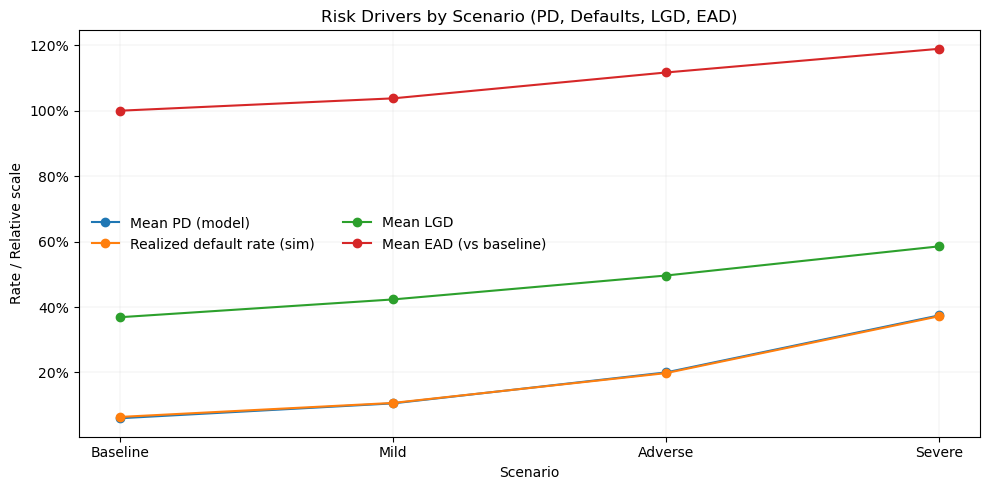

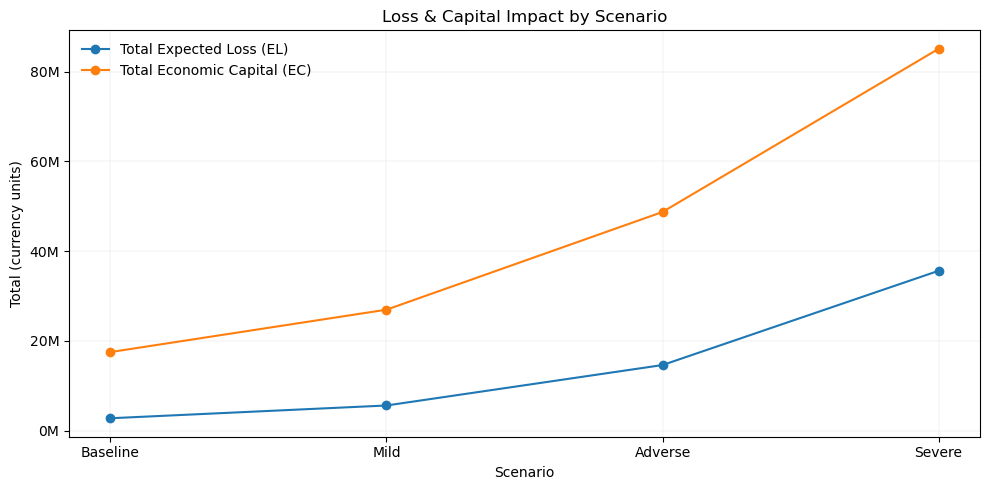

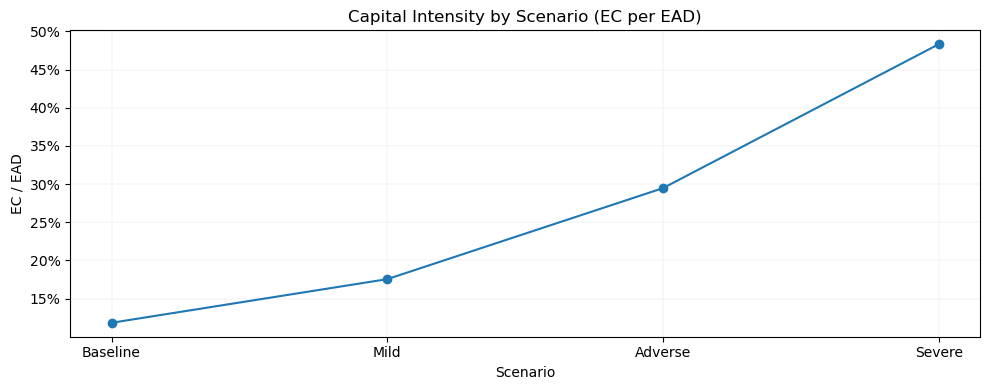

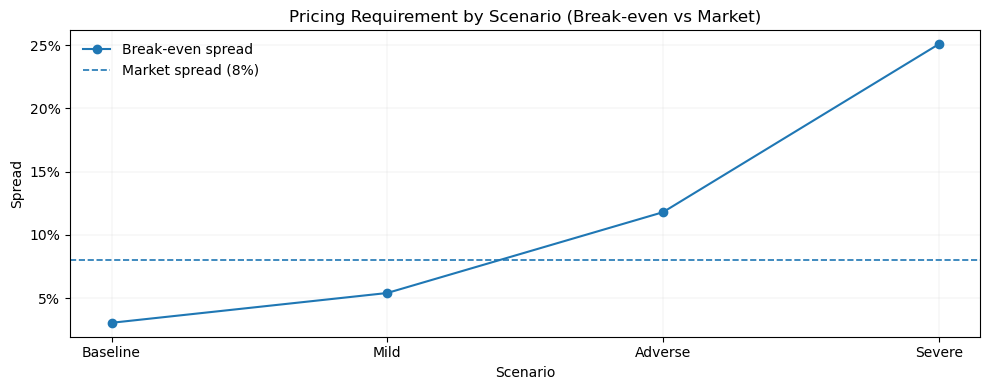

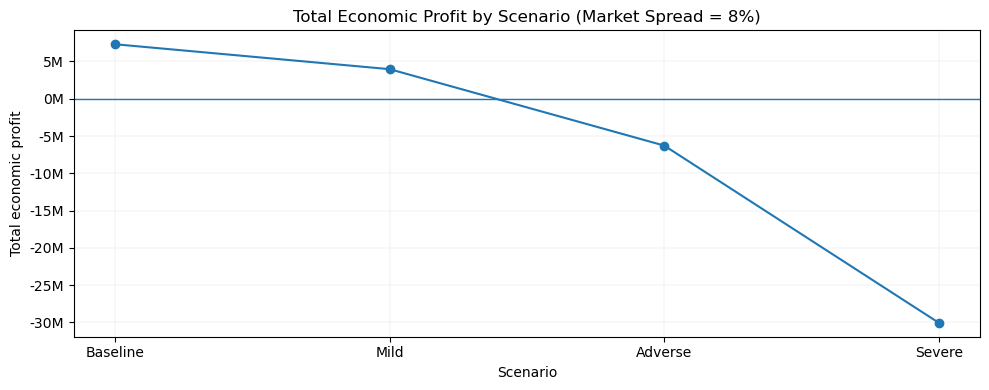

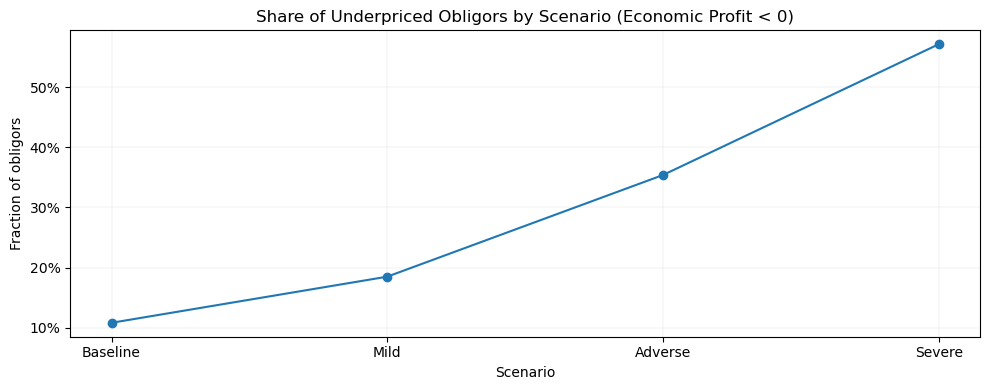

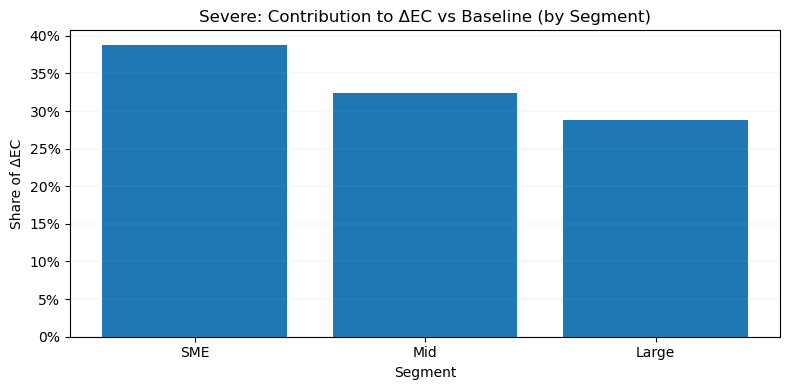

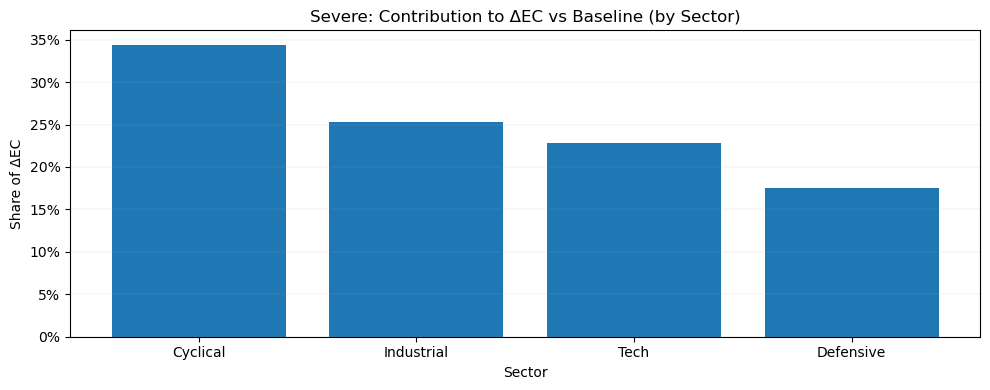

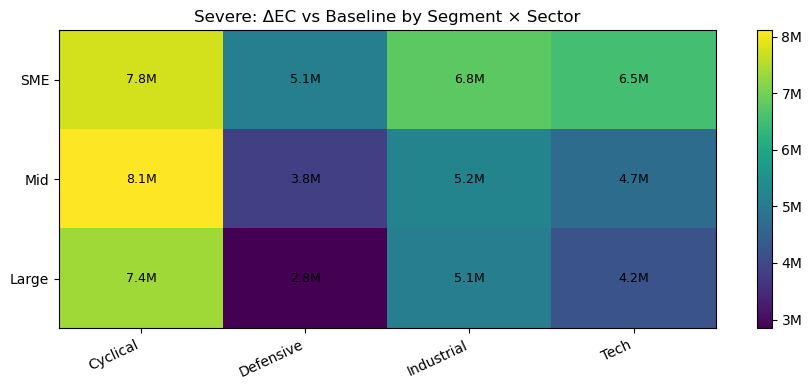

,break_even_spread,market_spread,total_EC,EC_per_EAD,total_economic_profit,pct_negative_obligors
scenario,,,,,,
Baseline,0.030647,0.08,1.752640e+07,0.118335,7.309667e+06,0.1084
Mild,0.054176,0.08,2.697038e+07,0.175478,3.969014e+06,0.1850
Adverse,0.117969,0.08,4.873681e+07,0.294643,-6.280369e+06,0.3538
Severe,0.250594,0.08,8.508074e+07,0.483061,-3.004639e+07,0.5710


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ============================================================
# EXECUTIVE, SLIDE-FRIENDLY PLOTS — "Risk → Capital → Pricing → Profit"
# ============================================================
# These plots are designed to tell a clean story to non-technical stakeholders:
#   1) How risk worsens across scenarios (PD / LGD / EAD, and realized defaults)
#   2) How that translates into losses and capital (EL / EC)
#   3) What pricing would be required (break-even spread)
#   4) What happens if the market charges a fixed spread (economic profit)
#   5) Who drives the stress impact (segment/sector contribution shares)
#
# Assumes you already computed the following tables earlier:
#   - port           : scenario-level portfolio summary (total_EL, total_EC, mean_PD, mean_LGD, mean_EAD, default_rate, etc.)
#   - port_delta     : scenario deltas vs baseline
#   - pricing_port   : scenario-level required spread summary (avg_required_spread, median_required_spread)
#   - profit_summary : scenario-level economic profit under FIXED_SPREAD (total_economic_profit, pct_negative_obligors)
#   - breakeven      : scenario-level break-even spread
#   - seg_out        : segment contribution table (scenario != Baseline) with contrib_share_delta_EC
#   - sec_out        : sector contribution table (scenario != Baseline) with contrib_share_delta_EC
#   - segsec         : segment×sector table with delta_EC_vs_base (optional but recommended)
#
# If any object names differ in your notebook, update references below.

# ----------------------------
# 0) Light formatting helpers
# ----------------------------
scenario_order = ["Baseline", "Mild", "Adverse", "Severe"]

def _fmt_millions(x, pos):
    return f"{x/1e6:.0f}M"

def _fmt_pct(x, pos):
    return f"{x*100:.0f}%"

def _safe_reindex(df, idx):
    return df.reindex(idx).copy()

# Make sure scenario tables are in the intended order
port_plot = _safe_reindex(port, scenario_order)
pricing_plot = _safe_reindex(pricing_port, scenario_order)
profit_plot = _safe_reindex(profit_summary, scenario_order)
be_plot = _safe_reindex(breakeven, scenario_order)

# ============================================================
# PLOT 1 — "Risk ladder": PD, LGD, EAD, and realized default rate
# ============================================================
# Why this plot:
#   Executives first need to see that the scenario engine behaves sensibly.
#   This plot shows the core risk drivers moving in the expected direction
#   as macro stress intensifies.
#
# What it answers:
#   "Are risk fundamentals (PD/LGD/EAD) and observed defaults increasing with stress?"
plt.figure(figsize=(10, 5))
x = np.arange(len(scenario_order))

plt.plot(scenario_order, port_plot["mean_PD"], marker="o", label="Mean PD (model)")
plt.plot(scenario_order, port_plot["default_rate"], marker="o", label="Realized default rate (sim)")
plt.plot(scenario_order, port_plot["mean_LGD"], marker="o", label="Mean LGD")
# For EAD we plot normalized to baseline to keep scale comparable
plt.plot(scenario_order, port_plot["mean_EAD"] / port_plot.loc["Baseline", "mean_EAD"], marker="o", label="Mean EAD (vs baseline)")

plt.title("Risk Drivers by Scenario (PD, Defaults, LGD, EAD)")
plt.ylabel("Rate / Relative scale")
plt.xlabel("Scenario")
plt.gca().yaxis.set_major_formatter(FuncFormatter(_fmt_pct))
plt.grid(True, linewidth=0.3, alpha=0.4)
plt.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()

# ============================================================
# PLOT 2 — Total Expected Loss vs Total Economic Capital
# ============================================================
# Why this plot:
#   Once stakeholders accept risk increases, the next question is the impact:
#   "How much loss and how much capital do we need under stress?"
#
# What it answers:
#   "How quickly do loss and capital requirements scale with macro stress?"
plt.figure(figsize=(10, 5))
plt.plot(scenario_order, port_plot["total_EL"], marker="o", label="Total Expected Loss (EL)")
plt.plot(scenario_order, port_plot["total_EC"], marker="o", label="Total Economic Capital (EC)")
plt.title("Loss & Capital Impact by Scenario")
plt.ylabel("Total (currency units)")
plt.xlabel("Scenario")
plt.gca().yaxis.set_major_formatter(FuncFormatter(_fmt_millions))
plt.grid(True, linewidth=0.3, alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# ============================================================
# PLOT 3 — Capital intensity: EC per EAD (a “capital ratio” proxy)
# ============================================================
# Why this plot:
#   Totals can be misleading when exposure size changes across scenarios.
#   EC_per_EAD shows capital required per unit of exposure.
#
# What it answers:
#   "How much more capital-intensive does the book become under stress?"
plt.figure(figsize=(10, 4))
plt.plot(scenario_order, port_plot["EC_per_EAD"], marker="o")
plt.title("Capital Intensity by Scenario (EC per EAD)")
plt.ylabel("EC / EAD")
plt.xlabel("Scenario")
plt.gca().yaxis.set_major_formatter(FuncFormatter(_fmt_pct))
plt.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout()
plt.show()

# ============================================================
# PLOT 4 — Pricing view: Break-even spread vs Market spread
# ============================================================
# Why this plot:
#   This is the bridge from risk management to business decision-making.
#   It shows the *minimum* spread required to avoid value destruction.
#
# What it answers:
#   "Is current market pricing sufficient under each scenario?"
plt.figure(figsize=(10, 4))
plt.plot(scenario_order, be_plot["break_even_spread"], marker="o", label="Break-even spread")
# If you used FIXED_SPREAD earlier, reuse it; otherwise set it here
FIXED_SPREAD = 0.08
plt.axhline(FIXED_SPREAD, linestyle="--", linewidth=1.2, label=f"Market spread ({FIXED_SPREAD:.0%})")
plt.title("Pricing Requirement by Scenario (Break-even vs Market)")
plt.ylabel("Spread")
plt.xlabel("Scenario")
plt.gca().yaxis.set_major_formatter(FuncFormatter(_fmt_pct))
plt.grid(True, linewidth=0.3, alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# ============================================================
# PLOT 5 — Economic Profit under fixed market spread
# ============================================================
# Why this plot:
#   Executives care about value creation. This plot quantifies
#   how flat market pricing behaves as scenarios worsen.
#
# What it answers:
#   "At which stress point does the portfolio become economically unprofitable?"
plt.figure(figsize=(10, 4))
plt.plot(scenario_order, profit_plot["total_economic_profit"], marker="o")
plt.axhline(0, linewidth=1.0)
plt.title(f"Total Economic Profit by Scenario (Market Spread = {FIXED_SPREAD:.0%})")
plt.ylabel("Total economic profit")
plt.xlabel("Scenario")
plt.gca().yaxis.set_major_formatter(FuncFormatter(_fmt_millions))
plt.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout()
plt.show()

# ============================================================
# PLOT 6 — Share of underpriced obligors (economic_profit < 0)
# ============================================================
# Why this plot:
#   A portfolio might still be slightly profitable while hiding
#   a large tail of underpriced firms.
#
# What it answers:
#   "How widespread is mispricing / value destruction under each scenario?"
plt.figure(figsize=(10, 4))
plt.plot(scenario_order, profit_plot["pct_negative_obligors"], marker="o")
plt.title("Share of Underpriced Obligors by Scenario (Economic Profit < 0)")
plt.ylabel("Fraction of obligors")
plt.xlabel("Scenario")
plt.gca().yaxis.set_major_formatter(FuncFormatter(_fmt_pct))
plt.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout()
plt.show()

# ============================================================
# PLOT 7 — Severe attribution: Segment contribution to Delta EC
# ============================================================
# Why this plot:
#   Once stress impact is clear, stakeholders ask “who drives it?”
#   This plot attributes the increase in EC vs baseline to segments.
#
# What it answers:
#   "Which segments explain most of the capital inflation in Severe?"
plt.figure(figsize=(8, 4))
sev_seg = seg_out[seg_out["scenario"] == "Severe"].copy()
sev_seg = sev_seg.sort_values("contrib_share_delta_EC", ascending=False)
plt.bar(sev_seg["segment"], sev_seg["contrib_share_delta_EC"])
plt.title("Severe: Contribution to ΔEC vs Baseline (by Segment)")
plt.ylabel("Share of ΔEC")
plt.xlabel("Segment")
plt.gca().yaxis.set_major_formatter(FuncFormatter(_fmt_pct))
plt.grid(True, axis="y", linewidth=0.3, alpha=0.4)
plt.tight_layout()
plt.show()

# ============================================================
# PLOT 8 — Severe attribution: Sector contribution to Delta EC
# ============================================================
# Why this plot:
#   Same attribution story, but by sector (often more actionable
#   for concentration limits and underwriting).
#
# What it answers:
#   "Which sectors explain most of the capital inflation in Severe?"
plt.figure(figsize=(10, 4))
sev_sec = sec_out[sec_out["scenario"] == "Severe"].copy()
sev_sec = sev_sec.sort_values("contrib_share_delta_EC", ascending=False)
plt.bar(sev_sec["sector"], sev_sec["contrib_share_delta_EC"])
plt.title("Severe: Contribution to ΔEC vs Baseline (by Sector)")
plt.ylabel("Share of ΔEC")
plt.xlabel("Sector")
plt.gca().yaxis.set_major_formatter(FuncFormatter(_fmt_pct))
plt.grid(True, axis="y", linewidth=0.3, alpha=0.4)
plt.tight_layout()
plt.show()

# ============================================================
# PLOT 9 — Optional: Segment × Sector “heatmap” of ΔEC in Severe
# ============================================================
# Why this plot:
#   Executives love a single picture that says “where is the pain?”
#   This heatmap shows which segment-sector combinations drive the largest ΔEC.
#
# What it answers:
#   "What are the hottest concentration cells under severe stress?"
#
# Note:
#   Uses matplotlib only (no seaborn). If segsec is not defined, skip.
if "segsec" in globals():
    sev_cells = segsec[segsec["scenario"] == "Severe"].copy()
    piv = sev_cells.pivot(index="segment", columns="sector", values="delta_EC_vs_base")
    piv = piv.reindex(index=["SME", "Mid", "Large"])  # consistent row order

    plt.figure(figsize=(9, 4))
    im = plt.imshow(piv.values, aspect="auto")
    plt.title("Severe: ΔEC vs Baseline by Segment × Sector")
    plt.xticks(np.arange(piv.shape[1]), piv.columns, rotation=25, ha="right")
    plt.yticks(np.arange(piv.shape[0]), piv.index)

    # Annotate cells so it’s readable in slides
    for i in range(piv.shape[0]):
        for j in range(piv.shape[1]):
            val = piv.values[i, j]
            if np.isfinite(val):
                plt.text(j, i, f"{val/1e6:.1f}M", ha="center", va="center", fontsize=9)

    cbar = plt.colorbar(im)
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(_fmt_millions))
    plt.tight_layout()
    plt.show()

# ============================================================
# OPTIONAL “ONE-SLIDE” KPI TABLE EXPORT (as a quick check)
# ============================================================
# Why:
#   Sometimes the fastest summary is a compact table with only
#   the KPIs an enterprise audience cares about.
#
# What it answers:
#   "Can we paste a single table into a deck with scenario KPIs?"
kpi = pd.DataFrame({
    "break_even_spread": be_plot["break_even_spread"],
    "market_spread": FIXED_SPREAD,
    "total_EC": port_plot["total_EC"],
    "EC_per_EAD": port_plot["EC_per_EAD"],
    "total_economic_profit": profit_plot["total_economic_profit"],
    "pct_negative_obligors": profit_plot["pct_negative_obligors"],
})
display(kpi)

# Technical readout 

## A. Risk drivers move in the right direction

From **Baseline → Mild → Adverse → Severe**, all core drivers increase monotonically:

- **Mean PD** rises from **~6% → ~37%**.  
- **Realized default rate** tracks PD closely (**~6% → ~37%**), which is what we expect in a coherent simulation: the Bernoulli default draws are consistent with the PD surface.  
- **Mean LGD** climbs from **~37% → ~59%** (recoveries worsen under stress).  
- **Mean EAD (relative to baseline)** grows from **100% → ~120%**, meaning exposures “pull” upward under stress (utilization effect).  

**What the plot shows:** the four lines are smooth and strictly increasing; **PD and realized defaults are almost on top of each other**; **LGD rises steadily**; **EAD increases moderately** (does not explode).

---

## B. Loss and capital scale nonlinearly (and EC > EL as expected)

In the **“Loss & Capital Impact”** chart:

- **Total EL** rises from **~2.8M (Baseline) → ~35.6M (Severe)**.  
- **Total EC** rises from **~17.5M (Baseline) → ~85.1M (Severe)**.  

**EC is always well above EL**, consistent with:  
\[
EC = EL + 2.33 \times UL
\]

**What the plot/data shows (truth check):**
- **EL increases ~12.8×** (2.79M → 35.63M)  
- **EC increases ~4.9×** (17.53M → 85.08M)  

The system becomes clearly **convex to stress** (the curve steepens after Mild).

---

## C. Capital intensity (EC/EAD) is the killer metric for executives

The **“Capital Intensity”** plot (EC per EAD):

- Baseline: **11.8%**  
- Mild: **17.5%**  
- Adverse: **29.5%**  
- Severe: **48.3%**  

This is a clean, strong signal: the portfolio becomes **~4× more capital-intensive** from Baseline to Severe.

**What the plot shows (truth check):** steady upward line that steepens in Adverse/Severe, ending **just under 50%**.

---

## D. Pricing gap: break-even vs market (8%) flips in Adverse

The **“Pricing Requirement”** plot:

**Break-even spread**
- Baseline: **3.06%**
- Mild: **5.42%**
- Adverse: **11.80%**
- Severe: **25.06%**

**Market spread line:** **8%**

So:
- In **Baseline** and **Mild**, market pricing (8%) is comfortably above break-even.  
- In **Adverse** and **Severe**, market pricing (8%) is below break-even → **structural underpricing**.

**What the plot shows (truth check):** the break-even line crosses the 8% dashed line between **Mild** and **Adverse**; in **Severe** it is massively above.

---

## E. Economic profit under 8%: positive → negative exactly when break-even crosses 8%

The **“Total Economic Profit”** plot matches the pricing gap:

- Baseline: **+7.31M**
- Mild: **+3.97M**
- Adverse: **−6.28M**
- Severe: **−30.05M**

This is internally consistent:
- When break-even < 8%, profit is positive.
- When break-even > 8%, profit turns negative (and collapses in Severe).

**What the plot shows (truth check):** the line crosses zero between **Mild** and **Adverse**, and dives deep negative in **Severe**.

---

## F. Underpriced obligors become widespread with stress

The **“Share of Underpriced Obligors”** plot:

- Baseline: **10.8%**
- Mild: **18.5%**
- Adverse: **35.4%**
- Severe: **57.1%**

Meaning: even before the portfolio becomes loss-making (Adverse), underpricing is already spreading; in Severe it’s the majority.

**What the plot shows (truth check):** monotonic increase; in Severe it is well above **50%**.

---

## G. Who drives Severe ΔEC (attribution is clear and consistent)

### By segment (Severe contribution to ΔEC vs baseline)
- SME: **~38.8%**
- Mid: **~32.4%**
- Large: **~28.8%**

So SMEs are the largest driver, but stress is broad-based (not concentrated in a single segment).

### By sector (Severe contribution to ΔEC vs baseline)
- Cyclical: **~34.4%**
- Industrial: **~25.3%**
- Tech: **~22.8%**
- Defensive: **~17.5%**

So **Cyclical** is the top driver; **Defensive** is the least.

### Heatmap (Severe ΔEC by segment×sector)
- The **Cyclical** column is highest across all segments, with especially large cells:
  - **Mid–Cyclical ~8.1M**
  - **SME–Cyclical ~7.8M**
  - **Large–Cyclical ~7.4M**
- **Defensive** cells are consistently lower (e.g., **Large–Defensive ~2.8M**).

**Truth from the heatmap labels:** biggest cell is **Mid–Cyclical ~8.1M**; cyclicals dominate across rows; defensive is systematically smaller.

---

# 2) What the company should do (practical recommendations)

## A. Fix pricing governance: move from flat spread → risk-based spread bands
- Use **break-even spread** as a minimum viability threshold per scenario (or per risk bucket).
- Add **risk-based pricing floors** at least by:
  - **Segment** (SME/Mid/Large)
  - **Sector** (Cyclical/Industrial/Tech/Defensive)
- In stress regimes, a flat **8%** spread becomes economically destructive; the tipping point appears already in **Adverse**.

## B. Capital planning: manage the EC/EAD explosion
- Track **EC/EAD** as a primary KPI (rises from **11.8% → 48.3%**).
- Set **risk appetite limits**: cap portfolio share in buckets that blow up capital intensity under stress (especially **Cyclical + SME** combinations).

## C. Concentration risk actions: de-risk the hotspots identified by attribution
Based on Severe attribution:
- Reduce or tightly price **Cyclical** exposures first (largest sector driver).
- Within Cyclical, apply strongest controls to:
  - **SME–Cyclical**
  - **Mid–Cyclical**
  - **Large–Cyclical** (still meaningful)
- **Defensive** is more resilient and can act as a stabilizer under stress.

## D. Early-warning monitoring: don’t wait for “Severe”
Deterioration is visible already in **Mild**:
- Profit shrinks (**7.3M → 4.0M**)
- Underpriced obligors rise (**10.8% → 18.5%**)

Add triggers:
- If % underpriced obligors exceeds **~20–25%**, tighten underwriting/pricing before the portfolio flips negative.

---

# 3) Plain-language conclusions

- When the economy is normal, charging **8%** works and the portfolio makes money.
- When things get a bit worse, it still works, but the “safety cushion” gets smaller.
- When things get bad, **8% is not enough** to cover losses and the cost of holding capital.
- In a crisis, **more than half** of clients would be underpriced and the portfolio would lose a lot of money.

**Where is the biggest danger?**
- **Small businesses** and **cyclical industries** (the ones that suffer most in recessions).

**What should the company do?**
- Stop charging the same price to everyone.
- Charge more to riskier groups (especially SMEs in cyclical sectors) or reduce exposure to them.
- Use this scenario analysis to adjust pricing and limits **before** a crisis hits.